### Forecast Olympic medals per country using Random Forest for years: 2012, 2016, 2020

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Summer-Olympic-medals-1976-to-2008.csv", encoding='latin1')
df.head()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal
0,Montreal,1976,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15316 entries, 0 to 15315
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   City          15316 non-null  object
 1   Year          15316 non-null  int64 
 2   Sport         15316 non-null  object
 3   Discipline    15316 non-null  object
 4   Event         15316 non-null  object
 5   Athlete       15316 non-null  object
 6   Gender        15316 non-null  object
 7   Country_Code  15316 non-null  object
 8   Country       15316 non-null  object
 9   Event_gender  15316 non-null  object
 10  Medal         15316 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.3+ MB


In [5]:
df.columns

Index(['City', 'Year', 'Sport', 'Discipline', 'Event', 'Athlete', 'Gender',
       'Country_Code', 'Country', 'Event_gender', 'Medal'],
      dtype='object')

In [6]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['won_medal'] = df['Medal'].notna().astype(int)

In [7]:
medals = df.groupby(['Country', 'Year'], as_index=False)['won_medal'].sum().rename(columns={'won_medal': 'medals'});
medals

,Country,Year,medals
0,Afghanistan,2008,1
1,Algeria,1984,2
2,Algeria,1992,2
3,Algeria,1996,3
4,Algeria,2000,5
...,...,...,...
554,Zambia,1984,1
555,Zambia,1996,1
556,Zimbabwe,1980,16
557,Zimbabwe,2004,3


In [8]:
# Create a full grid (fill missing years with 0 medals)
countries = medals['Country'].unique()
years = sorted(medals['Year'].unique())
grid = pd.MultiIndex.from_product([countries, years], names=['Country', 'Year']).to_frame(index=False)
medals_full = grid.merge(medals, on=['Country', 'Year'], how='left').fillna({'medals': 0})
medals_full['medals'] = medals_full['medals'].astype(int)
medals_full = medals_full.sort_values(['Country', 'Year']).reset_index(drop=True)

In [9]:
# Create lag features (previous Olympics performances)
for lag in [1, 2, 3, 4]:
    medals_full[f'medals_prev{lag}'] = medals_full.groupby('Country')['medals'].shift(lag).fillna(0)


In [10]:
# Mean and cumulative medals
medals_full['mean_prev4'] = medals_full[[f'medals_prev{i}' for i in range(1, 5)]].mean(axis=1)
medals_full['cum_medals'] = medals_full.groupby('Country')['medals'].cumsum() - medals_full['medals']

In [11]:
# Training data (up to 2008)
train = medals_full[medals_full['Year'] <= 2008].copy();
train

,Country,Year,medals,medals_prev1,medals_prev2,medals_prev3,medals_prev4,mean_prev4,cum_medals
0,Afghanistan,1976,0,0.0,0.0,0.0,0.0,0.00,0
1,Afghanistan,1980,0,0.0,0.0,0.0,0.0,0.00,0
2,Afghanistan,1984,0,0.0,0.0,0.0,0.0,0.00,0
3,Afghanistan,1988,0,0.0,0.0,0.0,0.0,0.00,0
4,Afghanistan,1992,0,0.0,0.0,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...
1138,Zimbabwe,1992,0,0.0,0.0,16.0,0.0,4.00,16
1139,Zimbabwe,1996,0,0.0,0.0,0.0,16.0,4.00,16
1140,Zimbabwe,2000,0,0.0,0.0,0.0,0.0,0.00,16
1141,Zimbabwe,2004,3,0.0,0.0,0.0,0.0,0.00,16


In [12]:
x = train[['Year', 'medals_prev1', 'medals_prev2', 'medals_prev3', 'medals_prev4', 'mean_prev4', 'cum_medals']]; x
y = train['medals']; y

0       0
1       0
2       0
3       0
4       0
       ..
1138    0
1139    0
1140    0
1141    3
1142    4
Name: medals, Length: 1143, dtype: int64

In [13]:
# ========== STEP 4: Train Random Forest ==========
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(x, y)
print("🌲 Random Forest model trained successfully!")

🌲 Random Forest model trained successfully!


In [14]:
# ========== STEP 5: Forecast future years ==========
future_years = [2012, 2016, 2020]
predictions = []

for country in countries:
    hist = medals_full[medals_full['Country'] == country].copy()
    for fy in future_years:
        prev = hist[hist['Year'] < fy].sort_values('Year')
        def get_val(y_look):
            row = prev[prev['Year'] == y_look]
            if not row.empty:
                return row['medals'].iloc[0]
            if not prev.empty:
                return prev['medals'].iloc[-1]
            return 0
        
        # Prepare features for prediction
        vals = [get_val(fy - 4*i) for i in range(1, 5)]
        features = pd.DataFrame([{
            'Year': fy,
            'medals_prev1': vals[0],
            'medals_prev2': vals[1],
            'medals_prev3': vals[2],
            'medals_prev4': vals[3],
            'mean_prev4': np.mean(vals),
            'cum_medals': prev['medals'].sum()
        }])
        pred = rf.predict(features)[0]
        pred_int = int(round(max(0, pred)))
        predictions.append({'Country': country, 'Year': fy, 'predicted_medals': pred_int})

In [15]:
hist = pd.concat([hist, pd.DataFrame({'Country':[country], 'Year':[fy], 'medals':[pred_int]})]);
hist

,Country,Year,medals,medals_prev1,medals_prev2,medals_prev3,medals_prev4,mean_prev4,cum_medals
1134,Zimbabwe,1976,0,0.0,0.0,0.0,0.0,0.00,0.0
1135,Zimbabwe,1980,16,0.0,0.0,0.0,0.0,0.00,0.0
1136,Zimbabwe,1984,0,16.0,0.0,0.0,0.0,4.00,16.0
1137,Zimbabwe,1988,0,0.0,16.0,0.0,0.0,4.00,16.0
1138,Zimbabwe,1992,0,0.0,0.0,16.0,0.0,4.00,16.0
1139,Zimbabwe,1996,0,0.0,0.0,0.0,16.0,4.00,16.0
1140,Zimbabwe,2000,0,0.0,0.0,0.0,0.0,0.00,16.0
1141,Zimbabwe,2004,3,0.0,0.0,0.0,0.0,0.00,16.0
1142,Zimbabwe,2008,4,3.0,0.0,0.0,0.0,0.75,19.0
0,Zimbabwe,2020,5,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pred_df = pd.DataFrame(predictions); pred_df

,Country,Year,predicted_medals
0,Afghanistan,2012,1
1,Afghanistan,2016,1
2,Afghanistan,2020,1
3,Algeria,2012,3
4,Algeria,2016,3
...,...,...,...
376,Zambia,2016,1
377,Zambia,2020,1
378,Zimbabwe,2012,4
379,Zimbabwe,2016,5


In [17]:
# ========== STEP 6: Visualizations ==========
# Merge historical and predictions
hist_df = medals_full[['Country','Year','medals']]
full_df = pd.concat([
    hist_df.assign(Source='Historical'),
    pred_df.rename(columns={'predicted_medals':'medals'}).assign(Source='Predicted')
]);
hist_df

,Country,Year,medals
0,Afghanistan,1976,0
1,Afghanistan,1980,0
2,Afghanistan,1984,0
3,Afghanistan,1988,0
4,Afghanistan,1992,0
...,...,...,...
1138,Zimbabwe,1992,0
1139,Zimbabwe,1996,0
1140,Zimbabwe,2000,0
1141,Zimbabwe,2004,3


In [18]:
# Top 10 countries overall
top_countries = hist_df.groupby('Country')['medals'].sum().nlargest(10).index;
top_countries

Index(['United States', 'Soviet Union', 'Australia', 'Germany', 'China',
       'Russia', 'East Germany', 'Italy', 'Romania', 'United Kingdom'],
      dtype='object', name='Country')

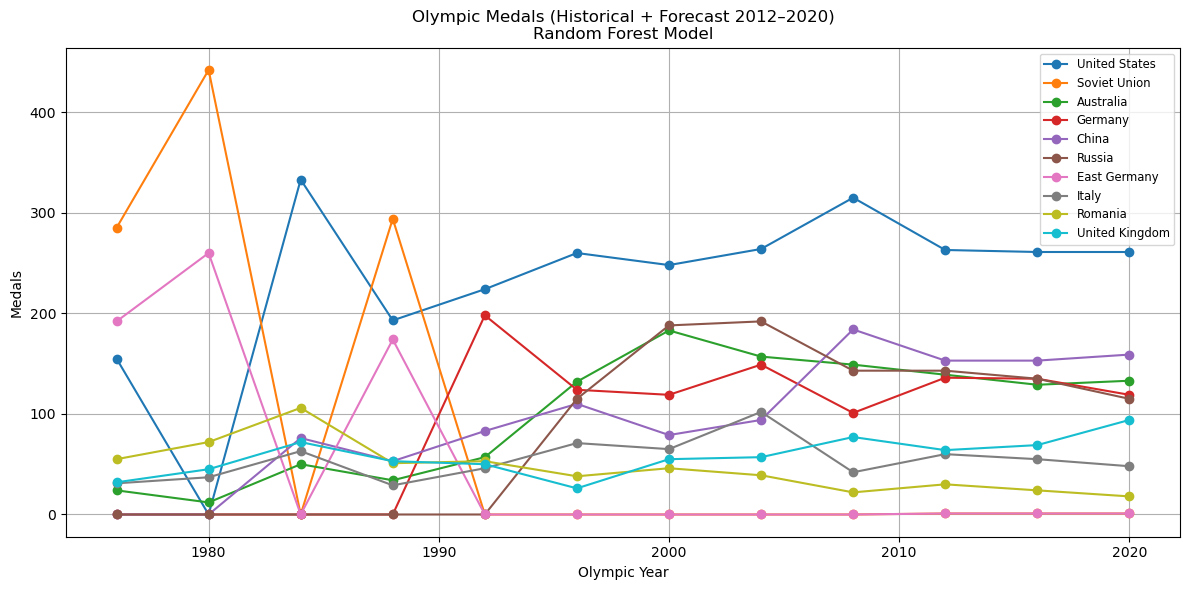

In [19]:
# --- Line Chart ---
plt.figure(figsize=(12,6))
for c in top_countries:
    temp = full_df[full_df['Country']==c].sort_values('Year')
    plt.plot(temp['Year'], temp['medals'], marker='o', label=c)
plt.title('Olympic Medals (Historical + Forecast 2012–2020)\nRandom Forest Model')
plt.xlabel('Olympic Year')
plt.ylabel('Medals')
plt.grid(True)
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("Olympic_medals_RF_forecast.png")
plt.show()

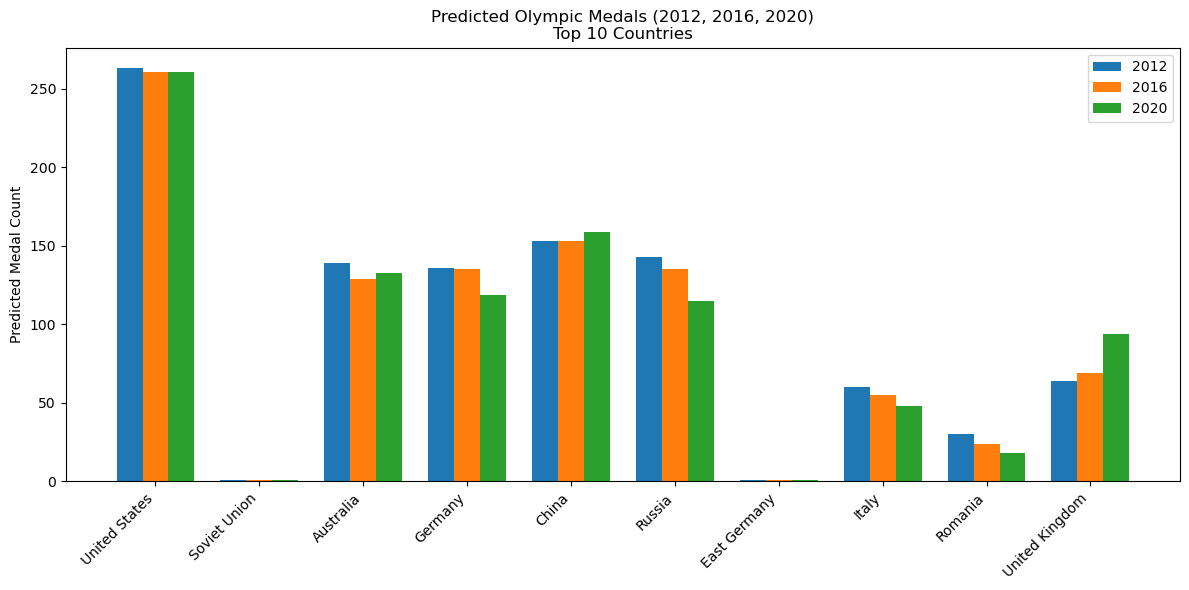

In [20]:
# --- Bar Chart (Predicted only) ---
pred_pivot = pred_df.pivot(index='Country', columns='Year', values='predicted_medals').fillna(0)
pred_pivot = pred_pivot.loc[top_countries]

x = np.arange(len(pred_pivot))
width = 0.25
plt.figure(figsize=(12,6))
for i, fy in enumerate(future_years):
    plt.bar(x + i*width, pred_pivot[fy], width, label=str(fy))
plt.xticks(x + width, pred_pivot.index, rotation=45, ha='right')
plt.title('Predicted Olympic Medals (2012, 2016, 2020)\nTop 10 Countries')
plt.ylabel('Predicted Medal Count')
plt.legend()
plt.tight_layout()
plt.savefig("predicted_olympic_medals_bar.png")
plt.show()

In [20]:
print("\n🏅 Predicted medal counts (Top 10 countries):")
print(pred_pivot.head(10).astype(int))


🏅 Predicted medal counts (Top 10 countries):
Year            2012  2016  2020
Country                         
United States    263   261   261
Soviet Union       1     1     1
Australia        139   129   133
Germany          136   135   119
China            153   153   159
Russia           143   135   115
East Germany       1     1     1
Italy             60    55    48
Romania           30    24    18
United Kingdom    64    69    94


In [21]:
# 💾 Save predicted medals for ALL countries (not just top 15)
# ============================================================

# Convert the full prediction DataFrame to a wide format
pred_all = pred_df.pivot(index='Country', columns='Year', values='predicted_medals').fillna(0).astype(int)

# Save to CSV
pred_all.to_csv("Predicted_Medals_All_Countries.csv", index=True)

print("\n✅ Predicted medal counts saved successfully!")
print("📂 Files created:")
print("   → Predicted_Medals_All_Countries.csv")


✅ Predicted medal counts saved successfully!
📂 Files created:
   → Predicted_Medals_All_Countries.csv
